In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('kitty_level_99', thickness, width, weaving_dir)
#  [ ear 214, ear 255, nose 39]

0.033273539253433904 0.0023291477477403733


In [4]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, width_scale = [0.2, 1.5])
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [6]:
# curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
#  (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
#  (0.0, 0.0, 0.0)))

In [7]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/kitty_level_99/kitty_level_99_dof.npy'))

In [8]:
curved_linkage.attraction_weight = 1e-1

In [9]:
elastic_rods.compute_equilibrium(curved_linkage, options = OPTS)

0	0.0169897	12.4464	12.4464	0.5	1
1	0.00879927	46.3668	46.3668	1	1
2	0.00599609	14.8372	14.8372	1	1
3	0.00519318	3.78046	3.78046	1	1
4	0.00439084	2.77426	2.77426	1	1
5	0.00354556	1.94621	1.94621	1	1
6	0.00277103	1.38812	1.38812	1	1
7	0.00208705	1.03256	1.03256	1	1
8	0.00146865	0.751235	0.751235	1	1
9	0.000929912	0.509029	0.509029	1	1
10	0.000520712	0.299734	0.299734	1	1
11	0.000278641	0.149831	0.149831	1	1
12	0.000173067	0.0748966	0.0748966	1	1
13	0.000135406	0.0414111	0.0414111	1	1
14	0.000118964	0.021991	0.021991	1	1
15	0.000104959	0.0110126	0.0110126	1	1
16	8.72823e-05	0.00565057	0.00565057	1	1
17	6.54322e-05	0.00330192	0.00330192	1	1
18	4.36018e-05	0.00245837	0.00245837	1	0
19	1.281e-05	0.0199652	0.0199652	1	0
20	1.26661e-05	0.00214629	0.00214629	1	0
21	1.26635e-05	0.00029657	0.00029657	1	0
22	1.26635e-05	5.09912e-06	5.09912e-06	1	0
23	1.26635e-05	3.36508e-09	3.36508e-09	1	0


In [10]:
design_parameters = np.load('results/new_kitty_1/new_kitty_1_dof.npy')[curved_linkage.numDoF():]
initial_design_parameters = curved_linkage.getExtendedDoFsPSRL()[curved_linkage.numDoF():]
second_design_parameters = np.load('results/kitty_level_4/kitty_level_4_dof.npy')[curved_linkage.numDoF():]
third_design_parameters = np.load('results/kitty_level_1/kitty_level_1_dof.npy')[curved_linkage.numDoF():]
fourth_design_parameters = np.load('results/kitty_level_0/kitty_level_0_dof.npy')[curved_linkage.numDoF():]

In [11]:
collect_design_parameters = []
collect_design_parameters.extend([initial_design_parameters * (1-idx) + second_design_parameters * idx for idx in np.linspace(0, 1, 30)])
collect_design_parameters.extend([second_design_parameters * (1-idx) + third_design_parameters * idx for idx in np.linspace(0, 1, 30)])
collect_design_parameters.extend([third_design_parameters * (1-idx) + fourth_design_parameters * idx for idx in np.linspace(0, 1, 30)])
collect_design_parameters.extend([fourth_design_parameters * (1-idx) + design_parameters * idx for idx in np.linspace(0, 1, 30)])

In [ ]:
np.save('cat_morphing_design_parameters.npy', collect_design_parameters)

In [ ]:
topColor =[51/256., 172/256., 255/256.]
bottomColor =[141/256., 141/256., 141/256.]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [ ]:
curved_linkage_view.update(scalarField=colors)

In [ ]:
def eqm_callback(prob, i):
#     if i % 5 == 0:
#         curved_linkage_view.update(scalarField=colors)
    pass

In [ ]:
# renderCam = curved_linkage_view.getCameraParams()

In [ ]:
# model_path_base = 'morphing_cat_results'
# video_folder = os.path.join(model_path_base, 'video')

In [ ]:
# np.save(os.path.join(video_folder, 'renderCam.npy'), renderCam)

### Generate cat morphing video

In [ ]:
OPTS.niter = 1000
def render_video(renderCam = None, framerate = 5):
    '''
    Render the equilibrium ribbon results offscreen for each iteration of the morphing sequence
    '''
    from PIL import Image
    import ffmpeg
    model_path_base = 'morphing_cat_results'
    video_folder = os.path.join(model_path_base, 'video')
    image_folder = os.path.join(video_folder, 'images')
    if not os.path.exists(image_folder):
        os.makedirs(image_folder) 
    if renderCam == None:
        renderCam = np.load(os.path.join(video_folder, 'renderCam.npy'))
    else:
        np.save(os.path.join(video_folder, 'renderCam.npy'), renderCam)

    def renderToFile(view, renderCam, path):
        orender = view.offscreenRenderer(width=2048, height=2048)
        orender.setCameraParams(renderCam)
        orender.render()
        orender.save(path)
    def write_distance_image(i):
        image_name = os.path.join(image_folder, 'iter_{:03d}.png'.format(i))
        if not os.path.isfile(image_name):
            curved_linkage.setDesignParameters(collect_design_parameters[i])
            with so(): elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
            curved_linkage_view.update(scalarField=colors)
            image_name = os.path.join(image_folder, 'iter_{:03d}.png'.format(i))
            renderToFile(curved_linkage_view, renderCam, image_name)
    def convert_png_to_jpg(i):
        image_name = os.path.join(image_folder, 'iter_{:03d}.png'.format(i))
        new_image_name = os.path.join(video_folder, 'images/iter_{:03d}.jpg'.format(i))
        if not os.path.isfile(new_image_name):
            im = Image.open(image_name)
            bg = Image.new('RGB', im.size, (255,255,255))
            bg.paste(im,im)
            bg.save(new_image_name)

    [write_distance_image(i) for i in range(len(collect_design_parameters))]
    [convert_png_to_jpg(i) for i in range(len(collect_design_parameters))]
    video_name = os.path.join(video_folder, '{}.mp4'.format('morphing_cat'))
    if os.path.isfile(video_name):
        os.remove(video_name)
    (ffmpeg
        .input(os.path.join(image_folder, 'iter_*.jpg'), pattern_type='glob', framerate=framerate)
        .output(video_name, crf=20, preset='slower', movflags='faststart', pix_fmt='yuv420p')
        .run()
    )

In [ ]:
render_video(framerate = 20)

In [ ]:
OPTS.niter = 1000
for curr_design_parameters in collect_design_parameters:
    curved_linkage.setDesignParameters(curr_design_parameters)
    with so(): elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

### Generate Curve Visualization

In [15]:
limits = np.load('cat_ribbon_5_limits.npy')

In [16]:
limits

array([1066.08557129,   -2.5       ,  305.00173845, -329.70082845])

Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88


../../../compute_curve_from_curvature.py:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = f.add_subplot(1,1,1)


Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88


KeyboardInterrupt: 

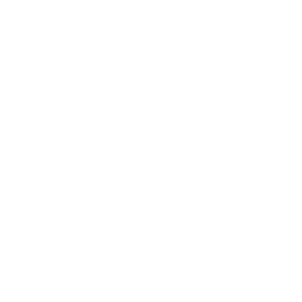

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

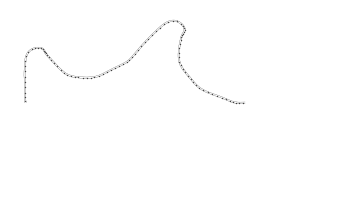

In [17]:
OPTS.niter = 1000
for i, curr_design_parameters in enumerate(collect_design_parameters):
    curved_linkage.setDesignParameters(curr_design_parameters)
    get_all_curve_pattern(curved_linkage, thickness, io.SUBDIVISION_RESOLUTION, 'morphing_ribbon', 'png', target_ribbon_width = 5, flip_angles = False, select_ribbon_index = [5], iteration_index='{:03d}'.format(i), limits=limits)

Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 88
Min Width  0.033273539253433904
Scale:  150.26955689674608
num s

KeyboardInterrupt: 

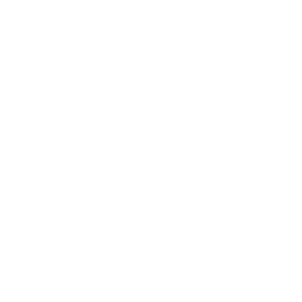

In [20]:
OPTS.niter = 1000
fig, host = plt.subplots()
host.set_aspect('equal')
all_limits = []
for i, curr_design_parameters in enumerate(collect_design_parameters):
    curved_linkage.setDesignParameters(curr_design_parameters)
    top_x, top_y, bottom_x, bottom_y, joint_x, joint_y, limits = get_all_curve_pattern(curved_linkage, thickness, io.SUBDIVISION_RESOLUTION, 'morphing_ribbon', 'png', target_ribbon_width = 5, flip_angles = False, select_ribbon_index = [5], iteration_index='{:03d}'.format(i), return_png_data=True)
    all_limits.append(limits)
#     plt.plot(top_x, top_y, '-', label='shifted up', linewidth = 0.2, color = 'black')
#     plt.plot(bottom_x, bottom_y, '-', label='shifted down', linewidth = 0.2, color = 'black')
#     plt.scatter(joint_x, joint_y, s = 0.1, facecolors='black', edgecolors='black')
# fig.savefig('all_ribbon.png', format='png', bbox_inches='tight', dpi = 200)

In [ ]:
# np.save('cat_ribbon_5_limits.npy', limits)

In [ ]:
import ffmpeg

In [ ]:
video_folder = 'morphing_ribbon'
video_name = os.path.join(video_folder, '{}.mp4'.format('5'))
PAD_OPTIONS = {
    'width':'ceil(iw/2)*2',
    'height':'ceil(ih/2)*2',
    'x':'0',
    'y':'0',
    'color': 'white'
}
if os.path.isfile(video_name):
    os.remove(video_name)
(ffmpeg
    .input(os.path.join(video_folder, '5_*.png'), pattern_type='glob', framerate=20)
    .filter_("pad", **PAD_OPTIONS)
    .output(video_name, crf=20, preset='slower', movflags='faststart', pix_fmt='yuv420p')
    .run()
)

### Plot Overlaying Ribbons

In [ ]:
video_folder = 'morphing_ribbon'
video_name = os.path.join(video_folder, '{}.mp4'.format('5'))

In [ ]:
import cv2

In [ ]:
merge_image = (cv2.imread(os.path.join(video_folder, '5_{:03d}.png'.format(0))))
for i in range(len(collect_design_parameters))[1:]:
    new_img = (cv2.imread(os.path.join(video_folder, '5_{:03d}.png'.format(i))))
    merge_image = cv2.bitwise_and(merge_image, new_img)
merge_image
merge_image = np.maximum(merge_image, 210 * np.ones_like(merge_image))
selected_image = cv2.bitwise_not(cv2.imread(os.path.join(video_folder, '5_{:03d}.png'.format(119))))
for i in range(4):
    new_img = cv2.imread(os.path.join(video_folder, '5_{:03d}.png'.format(i * 30)))
    selected_image = cv2.bitwise_or(selected_image, cv2.bitwise_not(new_img))
selected_image = cv2.bitwise_not(selected_image)

cv2.imwrite('overlay_ribbon.png', np.minimum(merge_image, selected_image))

### Panel Video

In [13]:
cat_root = 'morphing_cat_results/video/images/'
ribbon_root = 'morphing_ribbon/'
output_image_root = 'morphing_cat_results/morphing_cat_panel'
import cv2

In [25]:
for i in range(len(collect_design_parameters)):
    output_filename = os.path.join(output_image_root, '{:03d}.png'.format(i))
    if os.path.isfile(output_filename):
        continue
    img1 = cv2.imread(os.path.join(cat_root, 'iter_{:03d}.png'.format(i)))
    img1[np.where(np.sum(img1, axis = 2) == 0)] = [255, 255, 255] 
    img2 = cv2.imread(os.path.join(ribbon_root, '5_{:03d}.png'.format(i)))
    img2 = cv2.resize(img2, (2048, 1251))
    img2 = cv2.transpose(img2)
    bottom_row = np.concatenate((img1, img2), axis = 1)
    cv2.imwrite(output_filename, bottom_row)

In [27]:
import ffmpeg
video_folder = output_image_root
video_name = os.path.join(video_folder, '{}.mp4'.format('5'))
PAD_OPTIONS = {
    'width':'ceil(iw/2)*2',
    'height':'ceil(ih/2)*2',
    'x':'0',
    'y':'0',
    'color': 'white'
}
if os.path.isfile(video_name):
    os.remove(video_name)
(ffmpeg
    .input(os.path.join(video_folder, '*.png'), pattern_type='glob', framerate=20)
    .filter_("pad", **PAD_OPTIONS)
    .output(video_name, crf=20, preset='slower', movflags='faststart', pix_fmt='yuv420p')
    .run()
)

(None, None)

In [16]:
img1.shape, img2.shape

((2048, 2048, 3), (1184, 1939, 3))

In [18]:
2048 / 1939 * 1184

1250.558019597731